# Ejemplo Series de Tiempo

# Long Short-Term Memory (RNN)
A diferencia de modelos clásicos como ARMA, ARIMA, SARIMA etc., que funcionan bien cuando los datos son lineales y estacionarios, LSTM puede aprender relaciones complejas no lineales y de largo plazo en los datos.


- **No requiere estacionaridad**
#
Los modelos clásicos (ARIMA, SARIMA) exigen que la serie sea estacionaria (sin tendencia ni estacionalidad fuerte). LSTM puede trabajar con series no estacionarias: con tendencia, con cambios abruptos, con patrones que van y vienen.

- **Series más prolongadas (dependencias de largo plazo) y complejas**
#
LSTM logra capturar todos aquellos factores que puedan afectar el comportamiento de la serie. 

Si lo que ocurre hoy depende de lo que pasó hace mucho tiempo, LSTM es mucho mejor que un modelo ARIMA con pocos lags. 

- **Mismos criterios de evaluación:**
#
MSE, RMSE, MAE, etc., gráficas de valores reales vs predicciones. 

####
---
Nos vamos a olvidar de las diferenciaciones y tampoco vamos a necesitar identificar explícitamente la estacionalidad/tendencia.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error



## La Serie

Vamos a trabajar con la serie de tiempo AirPassenger. Los datos describen la cantidad total de pasajeros de una aerolínea por mes entre los años 1949 a 1960. Se presentan las primeras 6 filas del conjunto de datos:

In [9]:
tf.random.set_seed(123)
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
airPas = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print ('\n Parsed Data:')
airPas.head()



 Parsed Data:


/var/folders/9q/tfydcr6d56x3ht8bfg6vfx240000gn/T/ipykernel_68619/1894888467.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  airPas = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


A continuación podemos ver el gráfico de la serie. 

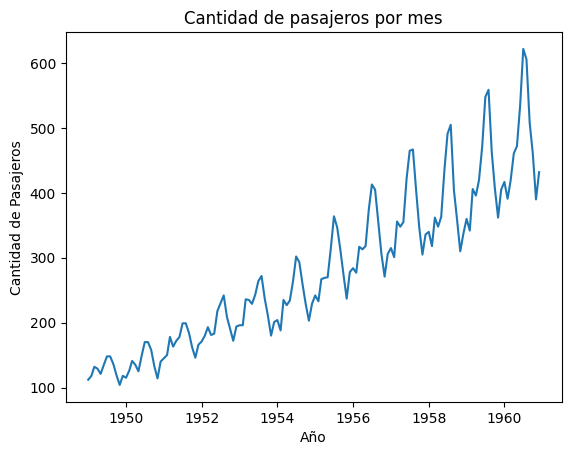

In [10]:
plt.plot(airPas)
plt.gca().set(title="Cantidad de pasajeros por mes", xlabel="Año", ylabel="Cantidad de Pasajeros")
plt.show()

(Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media)

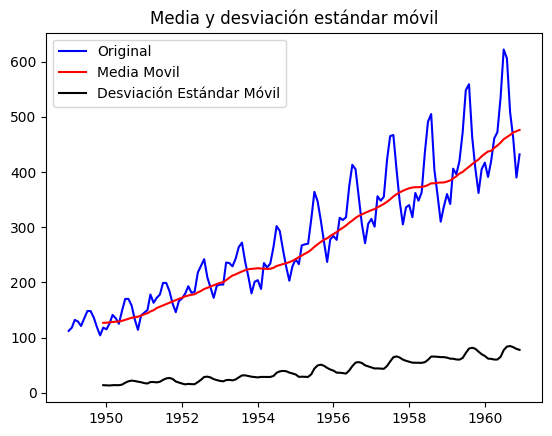

In [11]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = airPas.rolling(window=12).mean()
deMovil = airPas.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(airPas, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

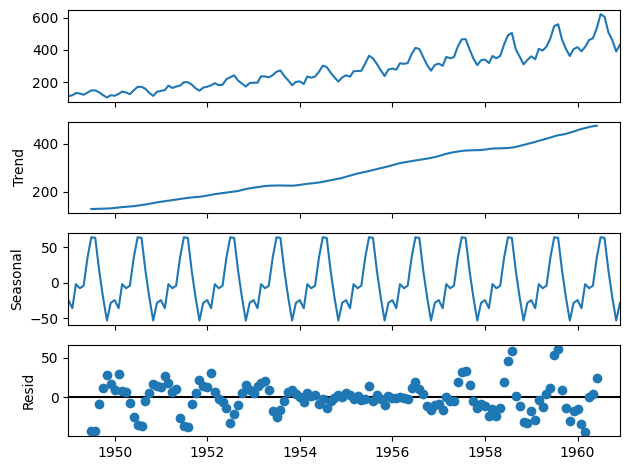

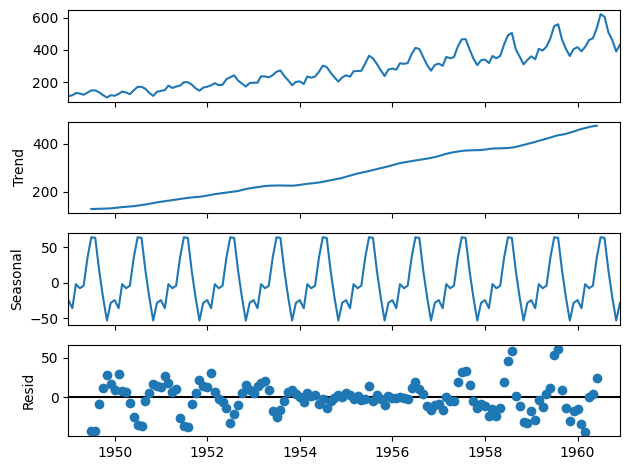

In [12]:
descomposicion = seasonal_decompose(airPas)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [13]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(airPas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.815369
p-value                        0.991880
# de retardos usados          13.000000
# de observaciones usadas    130.000000
Critical Value (1%)           -3.481682
Critical Value (5%)           -2.884042
Critical Value (10%)          -2.578770
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [14]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = airPas.diff()
ts_air_pas_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -2.889186
p-value                        0.046620
# de retardos usados          12.000000
# de observaciones usadas    131.000000
Critical Value (1%)           -3.481282
Critical Value (5%)           -2.883868
Critical Value (10%)          -2.578677
dtype: float64


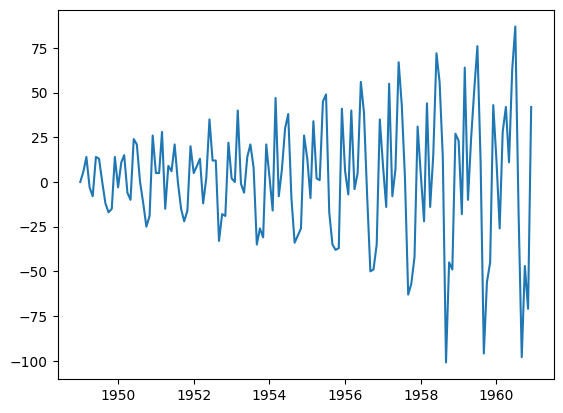

In [15]:
plt.plot(ts_air_pas_diff)

Como ya han podido explorarlo, las redes neuronales (como LSTM) son sensibles a la escala de los datos. Si hay valores grandes, junto con pequeños, la red puede tener dificultades al aprender, especialmente usando funciones de activación como tanh o sigmoid. (Además que esto facilita el entrenamiento). 

Como las redes neuronales trabajan mejor con los datos normalizados, vamos a normalizar la serie. 

Al normalizarla, estamos haciendo que la data tenga una media de 0 y una desviación estándar de 1. 

In [17]:
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(ts_air_pas_diff) 
ts_air_pas_scaled[1:7]


array([[ 0.11270364],
       [ 0.35137017],
       [-0.15579621],
       [-0.30496279],
       [ 0.35137017],
       [ 0.32153685]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [21]:
total_len = len(ts_air_pas_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_air_pas_scaled[:train_end]
validation = ts_air_pas_scaled[train_end:val_end]
test = ts_air_pas_scaled[val_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 144
Train: 86 | Validation: 28 | Test: 30


In [23]:
train, type(train)

(array([[-0.06629626],
        [ 0.11270364],
        [ 0.35137017],
        [-0.15579621],
        [-0.30496279],
        [ 0.35137017],
        [ 0.32153685],
        [-0.06629626],
        [-0.42429605],
        [-0.57346263],
        [-0.513796  ],
        [ 0.35137017],
        [-0.15579621],
        [ 0.26187022],
        [ 0.38120348],
        [-0.24529616],
        [-0.36462942],
        [ 0.64970333],
        [ 0.56020338],
        [-0.06629626],
        [-0.42429605],
        [-0.81212916],
        [-0.63312927],
        [ 0.70936996],
        [ 0.08287032],
        [ 0.08287032],
        [ 0.7690366 ],
        [-0.513796  ],
        [ 0.20220359],
        [ 0.11270364],
        [ 0.56020338],
        [-0.06629626],
        [-0.513796  ],
        [-0.72262921],
        [-0.54362932],
        [ 0.53037007],
        [ 0.08287032],
        [ 0.20220359],
        [ 0.32153685],
        [-0.42429605],
        [-0.00662963],
        [ 0.97786981],
        [ 0.29170354],
        [ 0

Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t.

#
```
DATA: [100, 120, 130, 150]
OUTPUT:
X = [[100], [120], [130]] (valores pasados, features)
y = [120, 130, 150] (valor actual, target)
```

##
Las series de tiempo por sí solas no vienen en un formato típico de aprendizaje supervisado (como una tabla de features y una variable objetivo).

Entonces lo que se hace es crear pares entrada–salida, como:

"Dado el valor en el mes anterior, ¿puedes predecir el valor del mes actual?"



In [24]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [25]:
x_train

array([[-0.06629626],
       [ 0.11270364],
       [ 0.35137017],
       [-0.15579621],
       [-0.30496279],
       [ 0.35137017],
       [ 0.32153685],
       [-0.06629626],
       [-0.42429605],
       [-0.57346263],
       [-0.513796  ],
       [ 0.35137017],
       [-0.15579621],
       [ 0.26187022],
       [ 0.38120348],
       [-0.24529616],
       [-0.36462942],
       [ 0.64970333],
       [ 0.56020338],
       [-0.06629626],
       [-0.42429605],
       [-0.81212916],
       [-0.63312927],
       [ 0.70936996],
       [ 0.08287032],
       [ 0.08287032],
       [ 0.7690366 ],
       [-0.513796  ],
       [ 0.20220359],
       [ 0.11270364],
       [ 0.56020338],
       [-0.06629626],
       [-0.513796  ],
       [-0.72262921],
       [-0.54362932],
       [ 0.53037007],
       [ 0.08287032],
       [ 0.20220359],
       [ 0.32153685],
       [-0.42429605],
       [-0.00662963],
       [ 0.97786981],
       [ 0.29170354],
       [ 0.29170354],
       [-1.05079569],
       [-0

In [27]:
y_train, type(y_train)

(array([ 0.11270364,  0.35137017, -0.15579621, -0.30496279,  0.35137017,
         0.32153685, -0.06629626, -0.42429605, -0.57346263, -0.513796  ,
         0.35137017, -0.15579621,  0.26187022,  0.38120348, -0.24529616,
        -0.36462942,  0.64970333,  0.56020338, -0.06629626, -0.42429605,
        -0.81212916, -0.63312927,  0.70936996,  0.08287032,  0.08287032,
         0.7690366 , -0.513796  ,  0.20220359,  0.11270364,  0.56020338,
        -0.06629626, -0.513796  , -0.72262921, -0.54362932,  0.53037007,
         0.08287032,  0.20220359,  0.32153685, -0.42429605, -0.00662963,
         0.97786981,  0.29170354,  0.29170354, -1.05079569, -0.60329595,
        -0.63312927,  0.5900367 , -0.00662963, -0.06629626,  1.12703639,
        -0.09612957, -0.24529616,  0.35137017,  0.56020338,  0.17237027,
        -1.11046233, -0.84196248, -0.99112906,  0.56020338,  0.02320369,
        -0.54362932,  1.3358696 , -0.30496279,  0.14253696,  0.82870323,
         1.06736976, -0.3347961 , -1.08062901, -0.9


## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote (batch), también conocido como tamaño del lote (batch size).
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Vamos a convertir los conjuntos en matrices de 3 dimensiones
(n_samples, time_steps, n_features)

In [28]:
(x_train.shape[0],1,1)

(85, 1, 1)

In [29]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

27

### Creamos el modelo.   
Vamos a utilizar solo una capa lstm  

LSTM(units, input_shape=(pasos, características), stateful=False)
- units: cantidad de neuronas. Cada una es como una "mini-memoria" que puede aprender patrones en secuencias.
- input_shape: pasos (lags) y features (cant de variables)
- batch_input_shape: Solo se usa si stateful=True. Igual que input_shape, pero le agregas el tamaño fijo del batch (batch_size). O sea: (batch_size, pasos, características).
- stateful: mantiene el estado (memoria) entre batches, ayuda para entender dependencias a largo plazo entre batches

Dense(1)
#
- Toma lo que sale de la LSTM y le aplica una transformación lineal con pesos y bias.
- En este caso, Dense(1) significa: produce una sola salida (por ejemplo, una predicción de un número, como el siguiente valor de la serie).

In [34]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 

In [35]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Vamos a entrenar el modelo. Para eso configuramos las epochs(épocas) que es la cantidad de iteraciones. Lo pondremos en 50.

In [36]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2263 - val_loss: 1.3351
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2229 - val_loss: 1.3175
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2210 - val_loss: 1.3030
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2194 - val_loss: 1.2909
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2182 - val_loss: 1.2806
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2172 - val_loss: 1.2718
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2164 - val_loss: 1.2643
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2158 - val_loss: 1.2577
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2152 - val_loss: 1.2520
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2148 - val_loss: 1.2468
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2144 - val_loss: 1.2422
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2141 - val_lo

Como vemos la pérdida empieza a disminuir bastante bien hasta la época 40 que parece estancarse. Hay bastante diferencia entre el modelo de entrenamiento y el de validación.  

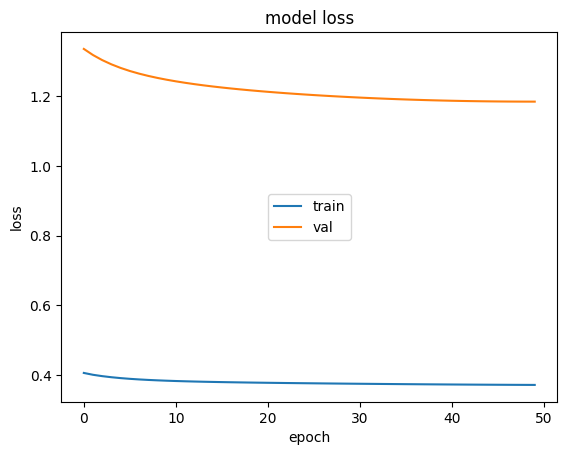

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [39]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2975 
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1840
Pérdida en Test
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2918


2.291750431060791

Ahora vamos a predecir con el modelo 1.  

In [66]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = airPas.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = airPas.values , n = len(airPas.values) - len(x_test))


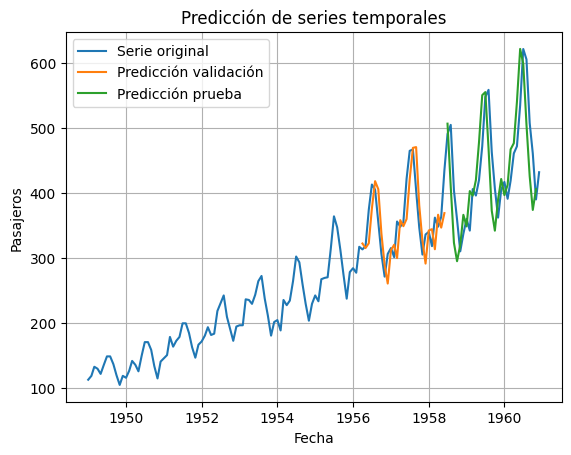

In [73]:
# df_val = pd.DataFrame(prediccion_val,index=airPas[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=airPas[train_prop+len(df_val):len(airPas)].index)
df_val = pd.DataFrame(prediccion_val, index=airPas[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=airPas[val_end:].index[:len(prediccion_test)])


plt.plot(airPas, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

